#Style Transfer using CycleGAN

## Problem statement:



*   The interpretation of medical scans using magnetic resonance imaging (MRI) requires the eye of an expert radiologist. But even experts can tend misdiagnose scans and/or disagree with alternate opinions.
*   Scans of differing contrasts (T1 and T2 MRI) can aid the diagnosing process by providing a more holistic view. However, obtaining different scans can be expensive and time-consuming.
*   Therefore, in this project, we aim to build an unpaired Generative Adversarial Network, which can produce a T2 image given an input T1 image and vice versa. Such a model would be vastly helpful in assisting doctors diagnose and treat patients faster and greatly reduce the treatment costs.











## **I. Importing libraries**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
from PIL import Image
import imageio.v2 as imageio
import os
import glob
from tensorflow.keras.utils import plot_model
from zipfile import ZipFile
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install tensorflow_addons
!pip install git+https://github.com/tensorflow/docs
import tensorflow_addons as tfa
import tensorflow_docs.vis.embed as embed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0xzkft2r
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-0xzkft2r
  Resolved https://github.com/tensorflow/docs to commit 460419a6369bd00bfc3ce7a7c92b0ca2a832c91b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.7.15.51478-py3-none-any.whl size=182590 sha256=c8dcd6583d0de54e5858ab4bc600466874b3199c

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## **II. Loading dataset**
Ran using colab, data loaded via GDrive.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
# In case not unzipped previously
if not os.path.exists('/content/drive/MyDrive/Style_Transfer_Capstone/MRI_T1_T2_Dataset'):
    !pip install patool
    import patoolib
    patoolib.extract_archive('/content/drive/MyDrive/Style_Transfer_Capstone/MRI+T1_T2+Dataset.RAR', outdir='/content/drive/MyDrive/Style_Transfer_Capstone/MRI_T1_T2_Dataset')
T1_train_path = '/content/drive/MyDrive/Style_Transfer_Capstone/MRI_T1_T2_Dataset/Tr1/TrainT1'
T2_train_path = '/content/drive/MyDrive/Style_Transfer_Capstone/MRI_T1_T2_Dataset/Tr2/TrainT2'

Mounted at /content/drive/


In case user requires local execution, uncomment below section and comment out snippet above. Assumes dataset in current working directory.

In [ ]:
#ds_dir = os.path.join(os.getcwd(), 'MRI+T1_T2+Dataset.RAR')
#op_dir = os.path.join(os.getcwd(), 'MRI_T1_T2_Dataset')
#if not os.path.exists(op_dir):
#    !pip install patool
#    import patoolib
#    patoolib.extract_archive(ds_dir, outdir=op_dir)

#T1_train_path = os.path.join(op_dir, 'Tr1', 'TrainT1')
#T2_train_path = os.path.join(op_dir, 'Tr2', 'TrainT2')

Loading input images

In [3]:
# Creating a function to load the images
def image_loader(path):
  images = []
  for image in os.listdir(path):
    image = Image.open(os.path.join(path, image))
    images.append(image)
  return np.array(images)

In [4]:
T1_images = image_loader(T1_train_path)
T2_images = image_loader(T2_train_path)

In [5]:
print("T1 shape:",  T1_images.shape)
print("T2 shape:",  T2_images.shape)

T1 shape: (43, 217, 181)
T2 shape: (46, 217, 181)


The T1 and T2 datasets have 43 and 46 images, respectively, clearly indicating that this is an unpaired approach problem.

Let us take a look at a random image from both datasets to get an idea of the contrast features.

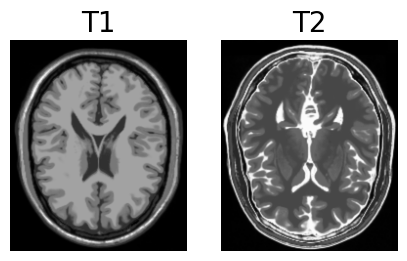

In [6]:
# Printing sample images from each category

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(T1_images[0], cmap="gray")
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(T2_images[0], cmap="gray")
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

## **III. Data preprocessing**

1) Reshaping datasets to include channel size

In [7]:
# reshaping array from (height, width) to (height, width, channel)
T1_images = T1_images.reshape(T1_images.shape[0], T1_images.shape[1], T1_images.shape[2], 1).astype("float32")
T2_images = T2_images.reshape(T2_images.shape[0], T2_images.shape[1], T2_images.shape[2], 1).astype("float32")

2) Image data augmentation

As there are only 43 and 46 images in the T1 and T2 domains respectively, we must augment both these datasets for a better training performance.

In [8]:
# Dataset augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal")])
T1_images = np.concatenate([data_augmentation(T1_images), T1_images], axis=0)
T2_images = np.concatenate([data_augmentation(T2_images), T2_images], axis=0)

3) Resizing and Normalization

In [9]:
# Function to normalize images
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

# Function to preprocess images

img_height = 128
img_width = 128

def preprocess(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, [*(img_height, img_width)]) # Resizing the image to (128, 128, 1)
    img = tf.image.random_crop(img, size=[*(img_height, img_width, 1)])
    img = normalize_img(img)
    return img

T1_images = [preprocess(image) for image in T1_images]
T2_images = [preprocess(image) for image in T2_images]

In [10]:
print('New dataset lengths:')
print("\n")
print("T1:", len(T1_images))
print("T2:", len(T2_images))

New dataset lengths:


T1: 86
T2: 92


4) Batch and shuffling

In [11]:
BUFFER_SIZE = 128
BATCH_SIZE = 1

T1_images = tf.data.Dataset.from_tensor_slices(T1_images).shuffle(BUFFER_SIZE, seed=42).batch(BATCH_SIZE)
T2_images = tf.data.Dataset.from_tensor_slices(T2_images).shuffle(BUFFER_SIZE, seed=42).batch(BATCH_SIZE)

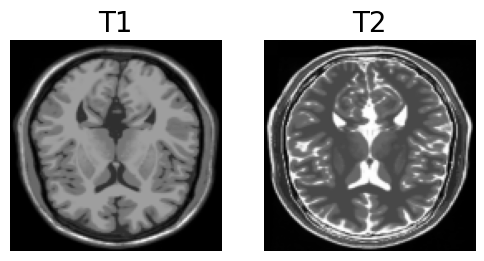

In [15]:
# Sample images after preprocessings steps

sample_T1 = next(iter(T1_images))
sample_T2 = next(iter(T2_images))

plt.figure(figsize= (6,6))
plt.subplot(1,2,1)
plt.imshow(sample_T1[0].numpy()[:, :], cmap="gray")
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(sample_T2[0].numpy()[:, :], cmap="gray")
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

## **IV. Model Building**

1) Downsampling

In [16]:
# Downsampling method: Leads to reduction in dimensions, achieved with convolutions
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(tfa.layers.InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

2) Upsampling

In [17]:
# Upsampling method: Achieved with Conv2DTranspose
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(tfa.layers.InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

3) U-Net Generator

In [18]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(128, 4, False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    up_stack = [
        upsample(512, 4, True),
        upsample(512, 4, True),
        upsample(512, 4, True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(128, 4)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh')
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

4) T1 and T2 Generators

In [19]:
generator_T2 = unet_generator()
generator_T1 = unet_generator()

In [20]:
# Checking generator params
generator_T2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          2048      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 128)          262400    ['sequential_1[0][0]']        
                                                                                                  
 sequential_3 (Sequential)   (None, 16, 16, 256)          524800    ['sequential_2[0][0]']        
                                                                                              

5) Discriminatiors

In [21]:
# function for discriminator
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[128, 128, 1], name="input_image")
    d = tf.keras.layers.Conv2D(
        64, (4, 4), strides=(2, 2), padding="same", kernel_initializer=initializer
    )(inp)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(inp)
    d = tf.keras.layers.Conv2D(
        128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=initializer
    )(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        256, (4, 4), strides=(2, 2), padding="same", kernel_initializer=initializer
    )(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        512, (4, 4), strides=(2, 2), padding="same", kernel_initializer=initializer
    )(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        512, (4, 4), padding="same", kernel_initializer=initializer
    )(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    last = tf.keras.layers.Conv2D(
        1, (4, 4), padding="same", kernel_initializer=initializer
    )(d)
    return tf.keras.models.Model(inp, last)

In [22]:
discriminator_T1 = discriminator()
discriminator_T2 = discriminator()

In [23]:
# Checking discriminator params
discriminator_T1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 128, 128, 1)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       2176      
                                                                 
 instance_normalization_26   (None, 64, 64, 128)       256       
 (InstanceNormalization)                                         
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 256)       524544    
                                                           

## **V. Model training**

1) Checking output of untrained generators

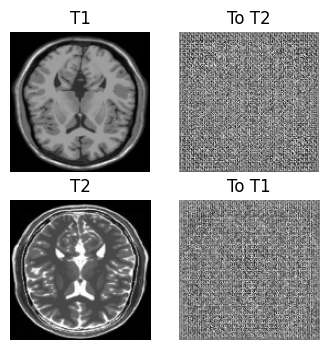

In [24]:
to_T2_image = generator_T2(sample_T1, training=False)
to_T1_image = generator_T1(sample_T2, training=False)

plt.figure(figsize=(4, 4))

imgs = [sample_T1, to_T2_image, sample_T2, to_T1_image]
title = ['T1', 'To T2', 'T2', 'To T1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

In [25]:
# Checking availability of GPUs for Colab Compute
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


2) Loss functions

In [26]:
# Declaring loss
BCE = tf.keras.losses.BinaryCrossentropy(from_logits = True)

2.1) Discriminator loss on real and fake data

In [27]:
def discriminator_loss(real, generated):
    real_loss = BCE(tf.ones_like(real), real)
    generated_loss = BCE(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

2.2) Generator loss based on the discriminator

In [28]:
def generator_loss(generated):
    return BCE(tf.ones_like(generated), generated)

2.3) Cycle Loss When we use both of Generators sequentially on a Input Image, we get Cycle Image and
the L1 Loss between these two is called Cycle Loss.

In [29]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

2.4) Identity Loss : When we provide input image to the Generator such that no translation is needed
because the image is already transformed, here also we take L1 Loss between Input and Output Image.

In [30]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

3) Optimizer

In [31]:
# We use Adam

generator_T2_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_T1_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_T1_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_T2_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

4) Initializing checkpoints

In [32]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_T2=generator_T2,
                           generator_T1=generator_T1,
                           discriminator_T2=discriminator_T2,
                           discriminator_T1=discriminator_T1,
                           generator_T2_optimizer=generator_T2_optimizer,
                           generator_T1_optimizer=generator_T1_optimizer,
                           discriminator_T2_optimizer=discriminator_T2_optimizer,
                           discriminator_T1_optimizer=discriminator_T1_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

5) Function for generating images while training

In [33]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(10, 6))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

6) Training function

In [34]:
@tf.function
def train_step(real_T1, real_T2):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator T2 translates T1 -> T2
        # Generator T1 translates T2 -> T1
        fake_T2 = generator_T2(real_T1, training=True)
        cycled_T1 = generator_T1(fake_T2, training=True)

        fake_T1 = generator_T1(real_T2, training=True)
        cycled_T2 = generator_T2(fake_T1, training=True) # check this

        # same_T2 and same_T2 are used for identity loss.
        same_T1 = generator_T1(real_T1, training=True)
        same_T2 = generator_T2(real_T2, training=True)

        disc_real_T1 = discriminator_T1(real_T1, training=True)
        disc_real_T2 = discriminator_T2(real_T2, training=True)

        disc_fake_T1 = discriminator_T1(fake_T1, training=True)
        disc_fake_T2 = discriminator_T2(fake_T2, training=True)

        # calculate the loss
        gen_T2_loss = generator_loss(disc_fake_T2)
        gen_T1_loss = generator_loss(disc_fake_T1)

        total_cycle_loss = calc_cycle_loss(real_T1, cycled_T1) + calc_cycle_loss(real_T2, cycled_T2) ## it caused error here

        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_T2_loss = gen_T2_loss + total_cycle_loss + identity_loss(real_T2, same_T2)
        total_gen_T1_loss = gen_T1_loss + total_cycle_loss + identity_loss(real_T1, same_T1)

        # Discriminator's loss
        disc_T1_loss = discriminator_loss(disc_real_T1, disc_fake_T1)
        disc_T2_loss = discriminator_loss(disc_real_T2, disc_fake_T2)

    # Calculate the gradients for generator and discriminator
    generator_T2_gradients = tape.gradient(total_gen_T2_loss, generator_T2.trainable_variables)
    generator_T1_gradients = tape.gradient(total_gen_T1_loss, generator_T1.trainable_variables)

    discriminator_T1_gradients = tape.gradient(disc_T1_loss, discriminator_T1.trainable_variables)
    discriminator_T2_gradients = tape.gradient(disc_T2_loss, discriminator_T2.trainable_variables)

    # Apply the gradients to the optimizer
    generator_T2_optimizer.apply_gradients(zip(generator_T2_gradients, generator_T2.trainable_variables))
    generator_T1_optimizer.apply_gradients(zip(generator_T1_gradients, generator_T1.trainable_variables))

    discriminator_T1_optimizer.apply_gradients(zip(discriminator_T1_gradients, discriminator_T1.trainable_variables))
    discriminator_T2_optimizer.apply_gradients(zip(discriminator_T2_gradients, discriminator_T2.trainable_variables))

# Model Training

In [35]:
# Edit as per requirements
EPOCHS = 150

for epoch in tqdm(range(1, EPOCHS+1)):
    print('Current epoch : ', epoch)
    for image_T1, image_T2 in tf.data.Dataset.zip((T1_images, T2_images)):
        train_step(image_T1, image_T2)
    generate_images(generator_T2, sample_T1, generator_T1, sample_T2)
    # Saving model at every 10th epoch
    if epoch % 10 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

Output hidden; open in https://colab.research.google.com to view.

Generating visualization for outputs

In [37]:
animation_file = 'cyclegan_transformation.gif'

with imageio.get_writer(animation_file, mode='I') as writer:
  filenames = glob.glob('image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


embed.embed_file(animation_file)

Output hidden; open in https://colab.research.google.com to view.